# **Data Quality Tests for Categorical Variables**
## **Customer Segmentation Dataset Analysis**

This notebook provides a comprehensive framework for data quality testing of categorical variables, with mathematical foundations and practical interpretations for the Mall Customers dataset.

### **Dataset Overview**
- **Source**: Mall Customer Segmentation Data
- **Size**: 200 customers
- **Categorical Variable**: Gender (Male/Female)
- **Purpose**: Customer segmentation for targeted marketing

### **Data Quality Framework**
We'll implement tests across two main dimensions:
1. **Consistency Tests**: Case sensitivity, spelling variations, encoding issues
2. **Completeness Tests**: Missing patterns, unknown categories, collection biases


In [2]:
%store -r

print("Project configuration:")
print(f"SLUG = {SLUG}")
print(f"DATA_DIR = {DATA_DIR}")
print(f"DATASET_KEY = {DATASET_KEY}")
print(f"FIG_DIR = {FIG_DIR}")
print(f"REP_DIR = {REP_DIR}")
print(f"NOTEBOOK_DIR = {NOTEBOOK_DIR}")

missing_vars = [var for var in ['SLUG', 'DATA_DIR', 'FIG_DIR', 'REP_DIR', 'NOTEBOOK_DIR', 'DATASET_KEY'] if var not in globals()]
print(f"Vars not found in globals: {missing_vars}")

# Set default values if variables are not found in store or are empty
if not SLUG:  # Check if empty string
    print(f"{SLUG=} is empty, initializing everything explicitly")
    SLUG = 'customer-segmentation'
    DATASET_KEY = 'vjchoudhary7/customer-segmentation-tutorial-in-python'
    GIT_ROOT = Path.cwd().parent.parent
    DATA_DIR = GIT_ROOT / 'data' / SLUG
    FIG_DIR = GIT_ROOT / 'figures' / SLUG
    REP_DIR = GIT_ROOT / 'reports' / SLUG
    NOTEBOOK_DIR = GIT_ROOT / 'notebooks' / SLUG

from pathlib import Path
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display
# Downloading data

base_df = pd.DataFrame()

CSV_PATH = Path(DATA_DIR) / "Mall_Customers.csv"
if not CSV_PATH.exists:
    print(f"CSV {CSV_PATH} does not exist. base_df will remain empty.")
else:
    base_df = pd.read_csv(CSV_PATH)
    print(f"CSV {CSV_PATH} loaded successfully.")

base_df.head()

Project configuration:
SLUG = customer-segmentation
DATA_DIR = /Users/ravisharma/workdir/eda_practice/data/customer-segmentation
DATASET_KEY = vjchoudhary7/customer-segmentation-tutorial-in-python
FIG_DIR = /Users/ravisharma/workdir/eda_practice/figures/customer-segmentation
REP_DIR = /Users/ravisharma/workdir/eda_practice/reports/customer-segmentation
NOTEBOOK_DIR = /Users/ravisharma/workdir/eda_practice/notebooks/customer-segmentation
Vars not found in globals: []
CSV /Users/ravisharma/workdir/eda_practice/data/customer-segmentation/Mall_Customers.csv loaded successfully.


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from scipy import stats
from scipy.stats import chi2_contingency, entropy
import warnings
warnings.filterwarnings('ignore')

df = base_df


In [6]:
# Focus on the categorical variable: Gender
categorical_col = 'Gender'
print(f"Analyzing categorical variable: {categorical_col}")
print(f"Unique values: {df[categorical_col].unique()}")
print(f"Value counts:\n{df[categorical_col].value_counts()}")
print(f"Null values: {df[categorical_col].isnull().sum()}")

# Basic statistics
print(f"\nBasic Statistics:")
print(f"Total observations: {len(df)}")
print(f"Unique categories: {df[categorical_col].nunique()}")
print(f"Most frequent category: {df[categorical_col].mode()[0]}")
print(f"Least frequent category: {df[categorical_col].value_counts().idxmin()}")


Analyzing categorical variable: Gender
Unique values: ['Male' 'Female']
Value counts:
Gender
Female    112
Male       88
Name: count, dtype: int64
Null values: 0

Basic Statistics:
Total observations: 200
Unique categories: 2
Most frequent category: Female
Least frequent category: Male


## **1. CONSISTENCY TESTS**

### **1.1 Case Sensitivity Test**

**Mathematical Foundation:**
The case sensitivity test measures inconsistencies in text casing that represent the same semantic category.

**Formula:**
$$\text{Case Inconsistency Ratio} = \frac{\text{Number of case variants}}{\text{Number of unique semantic categories}}$$

**Where:**
- Case variants = Different case representations of the same category
- Semantic categories = Actual distinct categories after case normalization

**Why it works:**
- Ratio = 1: Perfect consistency (each category has one case representation)
- Ratio > 1: Case inconsistencies exist
- Higher ratios indicate more severe case problems


In [7]:
def case_sensitivity_test(series, column_name):
    """
    Test for case sensitivity issues in categorical data
    
    Returns:
    - case_inconsistency_ratio: Mathematical measure of case problems
    - case_variants: Dictionary mapping normalized -> original variants
    - recommendations: Data quality recommendations
    """
    
    # Get original values
    original_values = series.dropna().astype(str)
    
    # Normalize to lowercase for comparison
    normalized_values = original_values.str.lower()
    
    # Count unique values before and after normalization
    original_unique = len(original_values.unique())
    normalized_unique = len(normalized_values.unique())
    
    # Calculate case inconsistency ratio
    case_inconsistency_ratio = original_unique / normalized_unique if normalized_unique > 0 else 0
    
    # Find case variants
    case_variants = {}
    for norm_val in normalized_values.unique():
        variants = original_values[normalized_values == norm_val].unique()
        if len(variants) > 1:
            case_variants[norm_val] = list(variants)
    
    # Generate recommendations
    recommendations = []
    if case_inconsistency_ratio > 1:
        recommendations.append(f"⚠️ Case inconsistencies detected (ratio: {case_inconsistency_ratio:.2f})")
        recommendations.append("🔧 Standardize case using .str.title() or .str.upper()")
        for norm, variants in case_variants.items():
            recommendations.append(f"   • '{norm}' appears as: {variants}")
    else:
        recommendations.append("✅ No case inconsistencies found")
    
    return {
        'case_inconsistency_ratio': case_inconsistency_ratio,
        'original_unique': original_unique,
        'normalized_unique': normalized_unique,
        'case_variants': case_variants,
        'recommendations': recommendations
    }

# Test case sensitivity
case_test_results = case_sensitivity_test(df[categorical_col], categorical_col)

print("=== CASE SENSITIVITY TEST RESULTS ===")
print(f"Case Inconsistency Ratio: {case_test_results['case_inconsistency_ratio']:.3f}")
print(f"Original unique values: {case_test_results['original_unique']}")
print(f"Normalized unique values: {case_test_results['normalized_unique']}")
print(f"Case variants found: {len(case_test_results['case_variants'])}")

print("\nRecommendations:")
for rec in case_test_results['recommendations']:
    print(rec)


=== CASE SENSITIVITY TEST RESULTS ===
Case Inconsistency Ratio: 1.000
Original unique values: 2
Normalized unique values: 2
Case variants found: 0

Recommendations:
✅ No case inconsistencies found


### **1.2 Spelling Variation Test**

**Mathematical Foundation:**
Uses Levenshtein distance to detect potential spelling variations that might represent the same category.

**Formula:**
$$\text{Levenshtein Distance}(s_1, s_2) = \min \begin{cases}
|s_1| & \text{if } |s_2| = 0 \\
|s_2| & \text{if } |s_1| = 0 \\
\text{lev}_{s_1,s_2}(|s_1|-1, |s_2|-1) + \mathbf{1}_{s_1[|s_1|] \neq s_2[|s_2|]} & \text{otherwise}
\end{cases}$$

**Similarity Score:**
$$\text{Similarity} = 1 - \frac{\text{Levenshtein Distance}}{\max(|s_1|, |s_2|)}$$

**Why it works:**
- Measures minimum edit operations (insertions, deletions, substitutions) needed to transform one string into another
- Similarity score ranges from 0 (completely different) to 1 (identical)
- Threshold-based detection identifies potential spelling variants


In [8]:
def levenshtein_distance(s1, s2):
    """Calculate Levenshtein distance between two strings"""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    
    if len(s2) == 0:
        return len(s1)
    
    previous_row = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def spelling_variation_test(series, similarity_threshold=0.8):
    """
    Test for spelling variations using Levenshtein distance
    
    Parameters:
    - similarity_threshold: Minimum similarity to flag as potential variant (0-1)
    
    Returns:
    - potential_variants: List of similar string pairs
    - similarity_matrix: Pairwise similarity scores
    - recommendations: Data quality recommendations
    """
    
    # Get unique values
    unique_values = series.dropna().astype(str).unique()
    n_values = len(unique_values)
    
    # Calculate similarity matrix
    similarity_matrix = np.zeros((n_values, n_values))
    potential_variants = []
    
    for i in range(n_values):
        for j in range(i+1, n_values):
            s1, s2 = unique_values[i], unique_values[j]
            
            # Calculate Levenshtein distance
            distance = levenshtein_distance(s1.lower(), s2.lower())
            max_len = max(len(s1), len(s2))
            
            # Calculate similarity score
            similarity = 1 - (distance / max_len) if max_len > 0 else 1
            similarity_matrix[i, j] = similarity_matrix[j, i] = similarity
            
            # Flag potential variants
            if similarity >= similarity_threshold and similarity < 1.0:
                potential_variants.append({
                    'string1': s1,
                    'string2': s2,
                    'similarity': similarity,
                    'distance': distance
                })
    
    # Generate recommendations
    recommendations = []
    if potential_variants:
        recommendations.append(f"⚠️ Found {len(potential_variants)} potential spelling variants")
        recommendations.append("🔧 Review and standardize similar categories:")
        for variant in potential_variants:
            recommendations.append(f"   • '{variant['string1']}' ↔ '{variant['string2']}' (similarity: {variant['similarity']:.3f})")
    else:
        recommendations.append("✅ No spelling variations detected")
    
    return {
        'potential_variants': potential_variants,
        'similarity_matrix': similarity_matrix,
        'unique_values': unique_values,
        'recommendations': recommendations
    }

# Test spelling variations
spelling_test_results = spelling_variation_test(df[categorical_col], similarity_threshold=0.7)

print("=== SPELLING VARIATION TEST RESULTS ===")
print(f"Unique values analyzed: {len(spelling_test_results['unique_values'])}")
print(f"Potential variants found: {len(spelling_test_results['potential_variants'])}")

print("\nRecommendations:")
for rec in spelling_test_results['recommendations']:
    print(rec)


=== SPELLING VARIATION TEST RESULTS ===
Unique values analyzed: 2
Potential variants found: 0

Recommendations:
✅ No spelling variations detected


### **1.3 Encoding Issues Test**

**Mathematical Foundation:**
Detects character encoding problems by analyzing byte patterns and non-ASCII characters.

**Formula for Character Entropy:**
$$H(X) = -\sum_{i=1}^{n} p(x_i) \log_2 p(x_i)$$

**Where:**
- $p(x_i)$ = Probability of character $x_i$ in the text
- Higher entropy suggests more diverse character usage (potential encoding issues)

**Non-ASCII Detection:**
$$\text{Non-ASCII Ratio} = \frac{\text{Count of non-ASCII characters}}{\text{Total characters}}$$

**Why it works:**
- Encoding issues often introduce unexpected characters or byte sequences
- High character entropy combined with non-ASCII characters suggests encoding problems
- Pattern analysis reveals systematic encoding corruption


In [9]:
def encoding_issues_test(series):
    """
    Test for character encoding issues in categorical data
    
    Returns:
    - character_entropy: Measure of character diversity
    - non_ascii_ratio: Proportion of non-ASCII characters
    - problematic_values: Values with potential encoding issues
    - recommendations: Data quality recommendations
    """
    
    # Get all text values
    text_values = series.dropna().astype(str)
    all_text = ' '.join(text_values)
    
    # Calculate character entropy
    char_counts = Counter(all_text)
    total_chars = len(all_text)
    char_probs = [count/total_chars for count in char_counts.values()]
    character_entropy = entropy(char_probs, base=2)
    
    # Count non-ASCII characters
    non_ascii_chars = sum(1 for char in all_text if ord(char) > 127)
    non_ascii_ratio = non_ascii_chars / total_chars if total_chars > 0 else 0
    
    # Find problematic values
    problematic_values = []
    encoding_patterns = [
        r'[^\x00-\x7F]',  # Non-ASCII characters
        r'\\x[0-9a-fA-F]{2}',  # Hex escape sequences
        r'\\u[0-9a-fA-F]{4}',  # Unicode escape sequences
        r'[Ã¢â‚¬â„¢]',  # Common UTF-8 encoding issues
    ]
    
    for value in text_values.unique():
        for pattern in encoding_patterns:
            if re.search(pattern, value):
                problematic_values.append({
                    'value': value,
                    'issue': 'Potential encoding issue',
                    'pattern': pattern
                })
                break
    
    # Generate recommendations
    recommendations = []
    if non_ascii_ratio > 0.01:  # More than 1% non-ASCII
        recommendations.append(f"⚠️ High non-ASCII character ratio: {non_ascii_ratio:.3f}")
        recommendations.append("🔧 Check file encoding (UTF-8, Latin-1, etc.)")
    
    if character_entropy > 4.0:  # High entropy threshold
        recommendations.append(f"⚠️ High character entropy: {character_entropy:.3f}")
        recommendations.append("🔧 Review for unusual character patterns")
    
    if problematic_values:
        recommendations.append(f"⚠️ Found {len(problematic_values)} values with encoding issues")
        recommendations.append("🔧 Review and re-encode problematic values:")
        for pv in problematic_values[:5]:  # Show first 5
            recommendations.append(f"   • '{pv['value']}'")
    
    if not recommendations:
        recommendations.append("✅ No encoding issues detected")
    
    return {
        'character_entropy': character_entropy,
        'non_ascii_ratio': non_ascii_ratio,
        'total_characters': total_chars,
        'problematic_values': problematic_values,
        'recommendations': recommendations
    }

# Test encoding issues
encoding_test_results = encoding_issues_test(df[categorical_col])

print("=== ENCODING ISSUES TEST RESULTS ===")
print(f"Character entropy: {encoding_test_results['character_entropy']:.3f}")
print(f"Non-ASCII ratio: {encoding_test_results['non_ascii_ratio']:.3f}")
print(f"Total characters analyzed: {encoding_test_results['total_characters']}")
print(f"Problematic values found: {len(encoding_test_results['problematic_values'])}")

print("\nRecommendations:")
for rec in encoding_test_results['recommendations']:
    print(rec)


=== ENCODING ISSUES TEST RESULTS ===
Character entropy: 2.688
Non-ASCII ratio: 0.000
Total characters analyzed: 1223
Problematic values found: 0

Recommendations:
✅ No encoding issues detected


## **2. COMPLETENESS TESTS**

### **2.1 Missing Value Pattern Analysis**

**Mathematical Foundation:**
Analyzes patterns in missing data to detect systematic biases or collection issues.

**Missing Completely At Random (MCAR) Test:**
$$\chi^2 = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i}$$

**Where:**
- $O_i$ = Observed frequency of missing pattern $i$
- $E_i$ = Expected frequency under MCAR assumption
- $k$ = Number of missing patterns

**Little's MCAR Test Statistic:**
$$T = -2 \log \Lambda \sim \chi^2_{df}$$

**Why it works:**
- MCAR: Missing values are completely random (no pattern)
- MAR: Missing values depend on observed data
- MNAR: Missing values depend on unobserved data
- Pattern analysis reveals systematic collection biases


In [10]:
def missing_pattern_analysis(dataframe, target_column):
    """
    Analyze missing value patterns to detect systematic biases
    
    Returns:
    - missing_percentage: Overall missing rate
    - pattern_analysis: Missing patterns across variables
    - mcar_test_result: Test for Missing Completely At Random
    - recommendations: Data quality recommendations
    """
    
    # Calculate missing percentages
    missing_stats = dataframe.isnull().sum()
    missing_percentage = (missing_stats / len(dataframe)) * 100
    
    # Focus on target column
    target_missing = missing_stats[target_column]
    target_missing_pct = missing_percentage[target_column]
    
    # Analyze missing patterns across all columns
    missing_patterns = dataframe.isnull().astype(int)
    pattern_counts = missing_patterns.value_counts()
    
    # Simple MCAR test using chi-square
    # Test if missing values are independent of other variables
    mcar_results = {}
    
    if target_missing > 0:
        # Test association between target missingness and other variables
        target_missing_indicator = dataframe[target_column].isnull()
        
        for col in dataframe.columns:
            if col != target_column and dataframe[col].dtype in ['object', 'category']:
                # Create contingency table
                contingency = pd.crosstab(target_missing_indicator, dataframe[col], dropna=False)
                
                if contingency.shape[0] > 1 and contingency.shape[1] > 1:
                    chi2, p_value, dof, expected = chi2_contingency(contingency)
                    mcar_results[col] = {
                        'chi2': chi2,
                        'p_value': p_value,
                        'significant': p_value < 0.05
                    }
    
    # Generate recommendations
    recommendations = []
    
    if target_missing_pct == 0:
        recommendations.append("✅ No missing values in target column")
    elif target_missing_pct < 5:
        recommendations.append(f"⚠️ Low missing rate: {target_missing_pct:.1f}%")
        recommendations.append("🔧 Consider simple imputation or removal")
    elif target_missing_pct < 20:
        recommendations.append(f"⚠️ Moderate missing rate: {target_missing_pct:.1f}%")
        recommendations.append("🔧 Investigate missing patterns before imputation")
    else:
        recommendations.append(f"🚨 High missing rate: {target_missing_pct:.1f}%")
        recommendations.append("🔧 Critical: Investigate data collection process")
    
    # MCAR test results
    significant_associations = [col for col, result in mcar_results.items() if result['significant']]
    if significant_associations:
        recommendations.append(f"⚠️ Missing values may not be MCAR (associated with: {significant_associations})")
        recommendations.append("🔧 Consider MAR/MNAR imputation methods")
    elif mcar_results:
        recommendations.append("✅ Missing values appear to be MCAR")
    
    return {
        'missing_percentage': target_missing_pct,
        'missing_count': target_missing,
        'total_observations': len(dataframe),
        'pattern_counts': pattern_counts,
        'mcar_test_results': mcar_results,
        'recommendations': recommendations
    }

# Test missing value patterns
missing_test_results = missing_pattern_analysis(df, categorical_col)

print("=== MISSING VALUE PATTERN ANALYSIS ===")
print(f"Missing percentage: {missing_test_results['missing_percentage']:.2f}%")
print(f"Missing count: {missing_test_results['missing_count']}")
print(f"Total observations: {missing_test_results['total_observations']}")

if missing_test_results['mcar_test_results']:
    print(f"\nMCAR Test Results:")
    for col, result in missing_test_results['mcar_test_results'].items():
        print(f"  {col}: χ² = {result['chi2']:.3f}, p = {result['p_value']:.3f} {'*' if result['significant'] else ''}")

print("\nRecommendations:")
for rec in missing_test_results['recommendations']:
    print(rec)


=== MISSING VALUE PATTERN ANALYSIS ===
Missing percentage: 0.00%
Missing count: 0
Total observations: 200

Recommendations:
✅ No missing values in target column


### **2.2 Unknown/Other Categories Test**

**Mathematical Foundation:**
Analyzes the prevalence and distribution of ambiguous categories that may indicate data collection issues.

**Ambiguity Score:**
$$A = \frac{\sum_{i \in \text{ambiguous}} f_i}{N}$$

**Where:**
- $f_i$ = Frequency of ambiguous category $i$
- $N$ = Total observations
- Ambiguous categories include: "Unknown", "Other", "N/A", "Unspecified", etc.

**Information Loss Measure:**
$$I_{loss} = -\sum_{i \in \text{ambiguous}} \frac{f_i}{N} \log_2\left(\frac{f_i}{N}\right)$$

**Why it works:**
- High ambiguity scores indicate poor data collection practices
- Information loss quantifies the reduction in analytical value
- Pattern analysis reveals systematic collection biases


In [11]:
def unknown_categories_test(series):
    """
    Test for ambiguous/unknown categories that reduce data quality
    
    Returns:
    - ambiguity_score: Proportion of ambiguous categories
    - information_loss: Information loss due to ambiguous categories
    - ambiguous_categories: List of detected ambiguous categories
    - recommendations: Data quality recommendations
    """
    
    # Define patterns for ambiguous categories
    ambiguous_patterns = [
        r'(?i)^unknown$',
        r'(?i)^other$',
        r'(?i)^n/?a$',
        r'(?i)^not?\s*specified$',
        r'(?i)^unspecified$',
        r'(?i)^missing$',
        r'(?i)^null$',
        r'(?i)^none$',
        r'(?i)^blank$',
        r'(?i)^empty$',
        r'(?i)^undefined$',
        r'(?i)^misc$',
        r'(?i)^miscellaneous$',
        r'^\s*$',  # Empty or whitespace only
        r'^-+$',   # Dashes only
        r'^\?+$',  # Question marks only
    ]
    
    # Get value counts
    value_counts = series.value_counts(dropna=False)
    total_observations = len(series)
    
    # Find ambiguous categories
    ambiguous_categories = []
    ambiguous_count = 0
    
    for value in value_counts.index:
        value_str = str(value) if pd.notna(value) else 'NaN'
        
        for pattern in ambiguous_patterns:
            if re.match(pattern, value_str):
                ambiguous_categories.append({
                    'category': value,
                    'count': value_counts[value],
                    'percentage': (value_counts[value] / total_observations) * 100,
                    'pattern_matched': pattern
                })
                ambiguous_count += value_counts[value]
                break
    
    # Calculate ambiguity score
    ambiguity_score = ambiguous_count / total_observations if total_observations > 0 else 0
    
    # Calculate information loss
    information_loss = 0
    if ambiguous_count > 0:
        for amb_cat in ambiguous_categories:
            prob = amb_cat['count'] / total_observations
            if prob > 0:
                information_loss -= prob * np.log2(prob)
    
    # Generate recommendations
    recommendations = []
    
    if ambiguity_score == 0:
        recommendations.append("✅ No ambiguous categories detected")
    elif ambiguity_score < 0.05:  # Less than 5%
        recommendations.append(f"⚠️ Low ambiguity score: {ambiguity_score:.3f}")
        recommendations.append("🔧 Consider improving data collection for ambiguous cases")
    elif ambiguity_score < 0.20:  # Less than 20%
        recommendations.append(f"⚠️ Moderate ambiguity score: {ambiguity_score:.3f}")
        recommendations.append("🔧 Review data collection process and validation rules")
    else:
        recommendations.append(f"🚨 High ambiguity score: {ambiguity_score:.3f}")
        recommendations.append("🔧 Critical: Redesign data collection to reduce ambiguous responses")
    
    if ambiguous_categories:
        recommendations.append("🔧 Detected ambiguous categories:")
        for amb_cat in ambiguous_categories:
            recommendations.append(f"   • '{amb_cat['category']}': {amb_cat['count']} ({amb_cat['percentage']:.1f}%)")
    
    if information_loss > 1.0:
        recommendations.append(f"⚠️ High information loss: {information_loss:.3f} bits")
        recommendations.append("🔧 Consider strategies to recover or impute ambiguous values")
    
    return {
        'ambiguity_score': ambiguity_score,
        'information_loss': information_loss,
        'ambiguous_count': ambiguous_count,
        'total_observations': total_observations,
        'ambiguous_categories': ambiguous_categories,
        'recommendations': recommendations
    }

# Test for unknown/ambiguous categories
unknown_test_results = unknown_categories_test(df[categorical_col])

print("=== UNKNOWN/AMBIGUOUS CATEGORIES TEST ===")
print(f"Ambiguity score: {unknown_test_results['ambiguity_score']:.3f}")
print(f"Information loss: {unknown_test_results['information_loss']:.3f} bits")
print(f"Ambiguous categories found: {len(unknown_test_results['ambiguous_categories'])}")
print(f"Total ambiguous observations: {unknown_test_results['ambiguous_count']}")

print("\nRecommendations:")
for rec in unknown_test_results['recommendations']:
    print(rec)


=== UNKNOWN/AMBIGUOUS CATEGORIES TEST ===
Ambiguity score: 0.000
Information loss: 0.000 bits
Ambiguous categories found: 0
Total ambiguous observations: 0

Recommendations:
✅ No ambiguous categories detected


### **2.3 Data Collection Bias Test**

**Mathematical Foundation:**
Analyzes category distributions to detect systematic biases in data collection processes.

**Chi-Square Goodness of Fit Test:**
$$\chi^2 = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i}$$

**Where:**
- $O_i$ = Observed frequency of category $i$
- $E_i$ = Expected frequency under null hypothesis (uniform or population distribution)
- $k$ = Number of categories

**Bias Detection Index:**
$$B = \frac{\max(f_i) - \min(f_i)}{\bar{f}}$$

**Where:**
- $\max(f_i)$ = Highest category frequency
- $\min(f_i)$ = Lowest category frequency  
- $\bar{f}$ = Mean category frequency

**Why it works:**
- Chi-square test detects deviations from expected distributions
- High bias index indicates over/under-representation of certain categories
- Systematic patterns suggest collection methodology issues


In [12]:
def collection_bias_test(series, expected_distribution=None):
    """
    Test for systematic biases in data collection
    
    Parameters:
    - expected_distribution: Dict of expected proportions (if known)
                           If None, assumes uniform distribution
    
    Returns:
    - chi2_statistic: Chi-square test statistic
    - p_value: P-value for goodness of fit test
    - bias_index: Measure of distribution skewness
    - category_analysis: Detailed category-wise analysis
    - recommendations: Data quality recommendations
    """
    
    # Get value counts
    observed_counts = series.value_counts(dropna=True)
    total_observations = observed_counts.sum()
    categories = observed_counts.index.tolist()
    n_categories = len(categories)
    
    # Calculate expected frequencies
    if expected_distribution is None:
        # Assume uniform distribution
        expected_counts = pd.Series([total_observations / n_categories] * n_categories, 
                                  index=categories)
    else:
        # Use provided distribution
        expected_counts = pd.Series([expected_distribution.get(cat, 0) * total_observations 
                                   for cat in categories], index=categories)
    
    # Perform chi-square goodness of fit test
    chi2_statistic = ((observed_counts - expected_counts) ** 2 / expected_counts).sum()
    degrees_of_freedom = n_categories - 1
    p_value = 1 - stats.chi2.cdf(chi2_statistic, degrees_of_freedom)
    
    # Calculate bias detection index
    max_freq = observed_counts.max()
    min_freq = observed_counts.min()
    mean_freq = observed_counts.mean()
    bias_index = (max_freq - min_freq) / mean_freq if mean_freq > 0 else 0
    
    # Category-wise analysis
    category_analysis = []
    for cat in categories:
        obs_count = observed_counts[cat]
        exp_count = expected_counts[cat]
        obs_prop = obs_count / total_observations
        exp_prop = exp_count / total_observations if total_observations > 0 else 0
        
        # Calculate standardized residual
        std_residual = (obs_count - exp_count) / np.sqrt(exp_count) if exp_count > 0 else 0
        
        category_analysis.append({
            'category': cat,
            'observed_count': obs_count,
            'expected_count': exp_count,
            'observed_proportion': obs_prop,
            'expected_proportion': exp_prop,
            'standardized_residual': std_residual,
            'over_represented': std_residual > 2,  # |z| > 2 is significant
            'under_represented': std_residual < -2
        })
    
    # Generate recommendations
    recommendations = []
    
    # Chi-square test interpretation
    if p_value < 0.001:
        recommendations.append(f"🚨 Highly significant deviation from expected distribution (p < 0.001)")
    elif p_value < 0.05:
        recommendations.append(f"⚠️ Significant deviation from expected distribution (p = {p_value:.3f})")
    else:
        recommendations.append(f"✅ Distribution consistent with expectations (p = {p_value:.3f})")
    
    # Bias index interpretation
    if bias_index > 2.0:
        recommendations.append(f"🚨 High collection bias detected (index: {bias_index:.2f})")
        recommendations.append("🔧 Critical: Review sampling methodology")
    elif bias_index > 1.0:
        recommendations.append(f"⚠️ Moderate collection bias (index: {bias_index:.2f})")
        recommendations.append("🔧 Consider stratified sampling or quota controls")
    else:
        recommendations.append(f"✅ Low collection bias (index: {bias_index:.2f})")
    
    # Category-specific recommendations
    over_rep = [cat for cat in category_analysis if cat['over_represented']]
    under_rep = [cat for cat in category_analysis if cat['under_represented']]
    
    if over_rep:
        recommendations.append(f"⚠️ Over-represented categories: {[cat['category'] for cat in over_rep]}")
    if under_rep:
        recommendations.append(f"⚠️ Under-represented categories: {[cat['category'] for cat in under_rep]}")
    
    return {
        'chi2_statistic': chi2_statistic,
        'p_value': p_value,
        'degrees_of_freedom': degrees_of_freedom,
        'bias_index': bias_index,
        'category_analysis': category_analysis,
        'recommendations': recommendations
    }

# Test for collection bias
# For gender, we might expect roughly equal distribution (50-50)
expected_gender_dist = {'Male': 0.5, 'Female': 0.5}

bias_test_results = collection_bias_test(df[categorical_col], expected_gender_dist)

print("=== DATA COLLECTION BIAS TEST ===")
print(f"Chi-square statistic: {bias_test_results['chi2_statistic']:.3f}")
print(f"P-value: {bias_test_results['p_value']:.3f}")
print(f"Degrees of freedom: {bias_test_results['degrees_of_freedom']}")
print(f"Bias index: {bias_test_results['bias_index']:.3f}")

print(f"\nCategory Analysis:")
for cat_analysis in bias_test_results['category_analysis']:
    print(f"  {cat_analysis['category']}:")
    print(f"    Observed: {cat_analysis['observed_count']} ({cat_analysis['observed_proportion']:.1%})")
    print(f"    Expected: {cat_analysis['expected_count']:.1f} ({cat_analysis['expected_proportion']:.1%})")
    print(f"    Std. Residual: {cat_analysis['standardized_residual']:.2f}")

print("\nRecommendations:")
for rec in bias_test_results['recommendations']:
    print(rec)


=== DATA COLLECTION BIAS TEST ===
Chi-square statistic: 2.880
P-value: 0.090
Degrees of freedom: 1
Bias index: 0.240

Category Analysis:
  Female:
    Observed: 112 (56.0%)
    Expected: 100.0 (50.0%)
    Std. Residual: 1.20
  Male:
    Observed: 88 (44.0%)
    Expected: 100.0 (50.0%)
    Std. Residual: -1.20

Recommendations:
✅ Distribution consistent with expectations (p = 0.090)
✅ Low collection bias (index: 0.24)


## **3. COMPREHENSIVE DATA QUALITY SUMMARY**

### **3.1 Integrated Quality Score**

**Mathematical Foundation:**
Combines all quality metrics into a single interpretable score.

**Composite Quality Score:**
$$Q = w_1 \cdot (1 - C) + w_2 \cdot (1 - M) + w_3 \cdot (1 - A) + w_4 \cdot (1 - B)$$

**Where:**
- $C$ = Consistency issues ratio (0-1)
- $M$ = Missing data ratio (0-1)  
- $A$ = Ambiguity score (0-1)
- $B$ = Bias index (normalized to 0-1)
- $w_i$ = Weights for each component (sum to 1)

**Quality Interpretation:**
- $Q \geq 0.9$: Excellent quality
- $0.7 \leq Q < 0.9$: Good quality
- $0.5 \leq Q < 0.7$: Fair quality
- $Q < 0.5$: Poor quality


In [13]:
def comprehensive_quality_assessment(case_results, spelling_results, encoding_results, 
                                    missing_results, unknown_results, bias_results,
                                    weights=None):
    """
    Generate comprehensive data quality assessment
    
    Parameters:
    - weights: Dict with keys ['consistency', 'completeness', 'ambiguity', 'bias']
              Default: equal weights (0.25 each)
    
    Returns:
    - quality_score: Overall quality score (0-1)
    - component_scores: Individual component scores
    - quality_grade: Qualitative assessment
    - priority_actions: Prioritized recommendations
    """
    
    if weights is None:
        weights = {'consistency': 0.25, 'completeness': 0.25, 'ambiguity': 0.25, 'bias': 0.25}
    
    # Normalize individual metrics to 0-1 scale (higher = better quality)
    
    # Consistency score (1 - normalized issues)
    consistency_issues = max(0, case_results['case_inconsistency_ratio'] - 1)  # Only count excess
    consistency_issues += len(spelling_results['potential_variants']) / 10  # Normalize by reasonable max
    consistency_issues += min(1, encoding_results['non_ascii_ratio'] * 10)  # Scale non-ASCII ratio
    consistency_score = max(0, 1 - min(1, consistency_issues))
    
    # Completeness score (1 - missing ratio)
    completeness_score = 1 - (missing_results['missing_percentage'] / 100)
    
    # Ambiguity score (1 - ambiguity ratio)
    ambiguity_score = 1 - unknown_results['ambiguity_score']
    
    # Bias score (1 - normalized bias index)
    normalized_bias = min(1, bias_results['bias_index'] / 3)  # Normalize by reasonable max
    bias_score = 1 - normalized_bias
    
    # Calculate weighted composite score
    quality_score = (weights['consistency'] * consistency_score +
                    weights['completeness'] * completeness_score +
                    weights['ambiguity'] * ambiguity_score +
                    weights['bias'] * bias_score)
    
    # Determine quality grade
    if quality_score >= 0.9:
        quality_grade = "Excellent"
        grade_emoji = "🟢"
    elif quality_score >= 0.7:
        quality_grade = "Good"
        grade_emoji = "🟡"
    elif quality_score >= 0.5:
        quality_grade = "Fair"
        grade_emoji = "🟠"
    else:
        quality_grade = "Poor"
        grade_emoji = "🔴"
    
    # Component scores for detailed analysis
    component_scores = {
        'consistency': consistency_score,
        'completeness': completeness_score,
        'ambiguity': ambiguity_score,
        'bias': bias_score
    }
    
    # Priority actions based on lowest scores
    priority_actions = []
    
    # Sort components by score (lowest first = highest priority)
    sorted_components = sorted(component_scores.items(), key=lambda x: x[1])
    
    for component, score in sorted_components:
        if score < 0.7:  # Only include components needing attention
            if component == 'consistency':
                priority_actions.append("🔧 HIGH PRIORITY: Address consistency issues (case, spelling, encoding)")
            elif component == 'completeness':
                priority_actions.append("🔧 HIGH PRIORITY: Investigate missing data patterns")
            elif component == 'ambiguity':
                priority_actions.append("🔧 HIGH PRIORITY: Reduce ambiguous/unknown categories")
            elif component == 'bias':
                priority_actions.append("🔧 HIGH PRIORITY: Address collection bias in sampling")
    
    if not priority_actions:
        priority_actions.append("✅ No critical quality issues identified")
    
    return {
        'quality_score': quality_score,
        'quality_grade': quality_grade,
        'grade_emoji': grade_emoji,
        'component_scores': component_scores,
        'priority_actions': priority_actions,
        'weights_used': weights
    }

# Generate comprehensive assessment
quality_assessment = comprehensive_quality_assessment(
    case_test_results, spelling_test_results, encoding_test_results,
    missing_test_results, unknown_test_results, bias_test_results
)

print("=" * 50)
print("🎯 COMPREHENSIVE DATA QUALITY ASSESSMENT")
print("=" * 50)

print(f"\n{quality_assessment['grade_emoji']} OVERALL QUALITY: {quality_assessment['quality_grade']}")
print(f"📊 Quality Score: {quality_assessment['quality_score']:.3f} / 1.000")

print(f"\n📈 COMPONENT BREAKDOWN:")
for component, score in quality_assessment['component_scores'].items():
    emoji = "🟢" if score >= 0.9 else "🟡" if score >= 0.7 else "🟠" if score >= 0.5 else "🔴"
    print(f"  {emoji} {component.title()}: {score:.3f}")

print(f"\n🎯 PRIORITY ACTIONS:")
for action in quality_assessment['priority_actions']:
    print(f"  {action}")

print(f"\n⚖️ Weights Used: {quality_assessment['weights_used']}")


🎯 COMPREHENSIVE DATA QUALITY ASSESSMENT

🟢 OVERALL QUALITY: Excellent
📊 Quality Score: 0.980 / 1.000

📈 COMPONENT BREAKDOWN:
  🟢 Consistency: 1.000
  🟢 Completeness: 1.000
  🟢 Ambiguity: 1.000
  🟢 Bias: 0.920

🎯 PRIORITY ACTIONS:
  ✅ No critical quality issues identified

⚖️ Weights Used: {'consistency': 0.25, 'completeness': 0.25, 'ambiguity': 0.25, 'bias': 0.25}


### **3.2 Visualization of Quality Metrics**


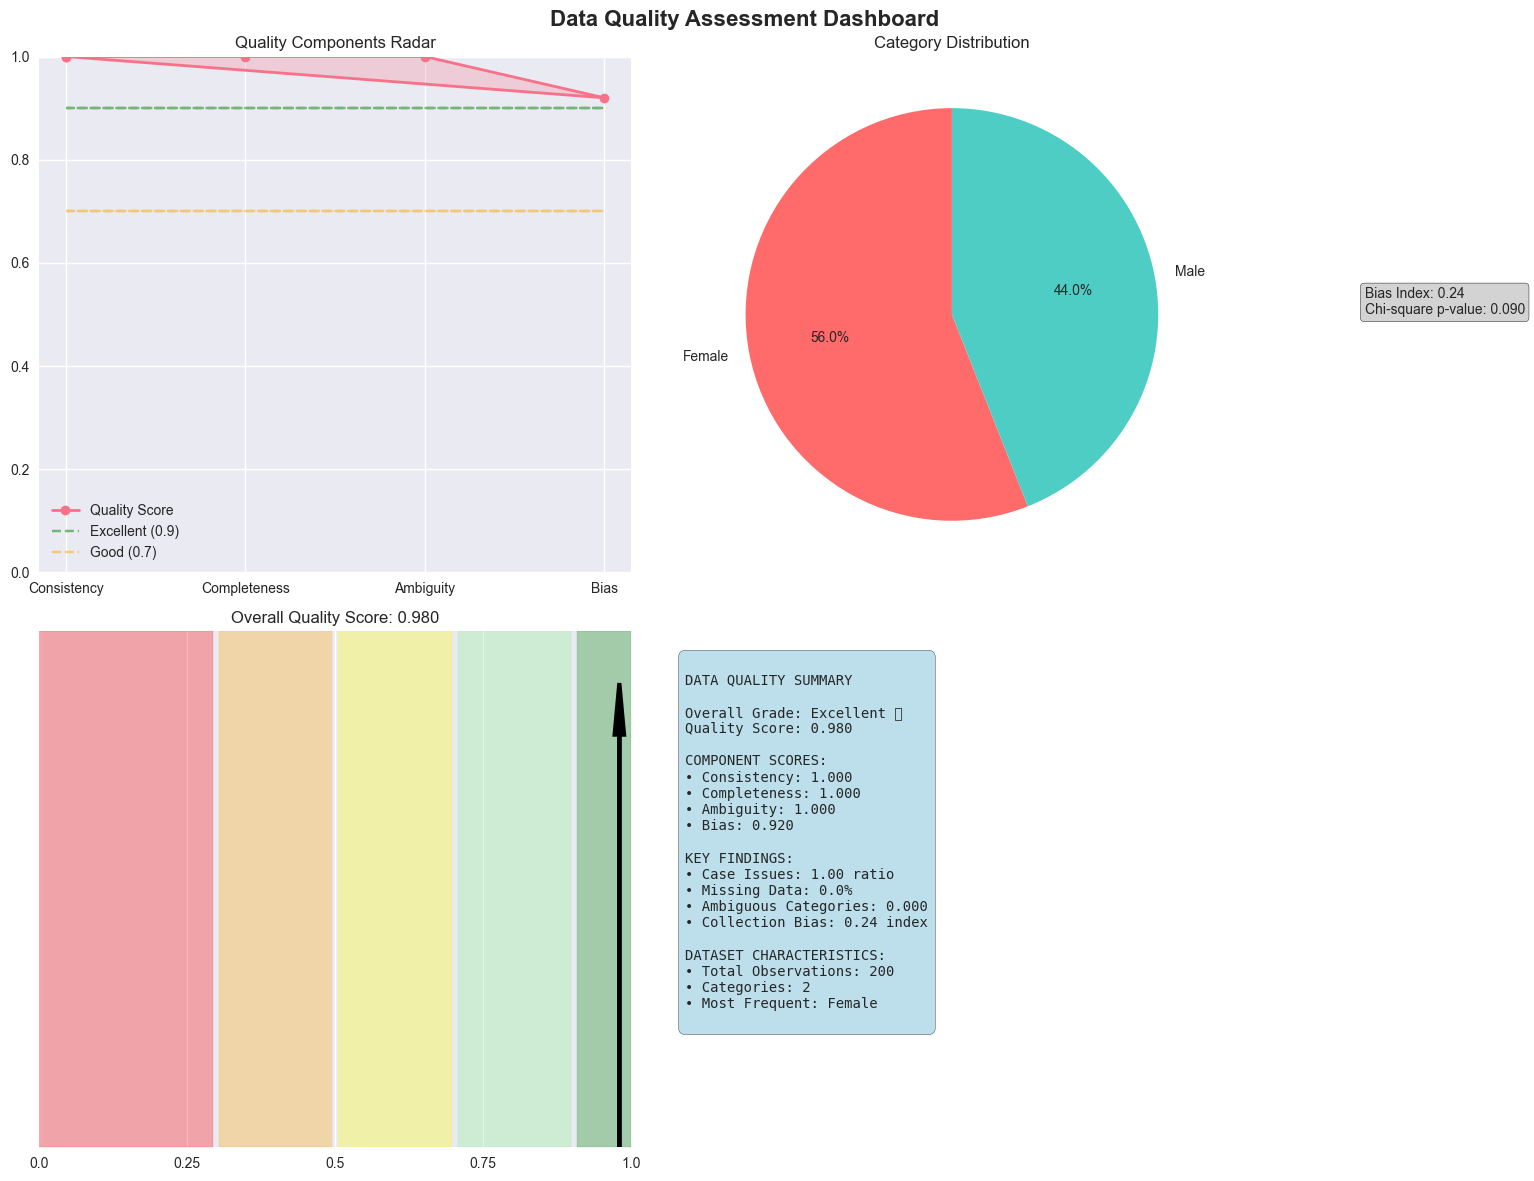

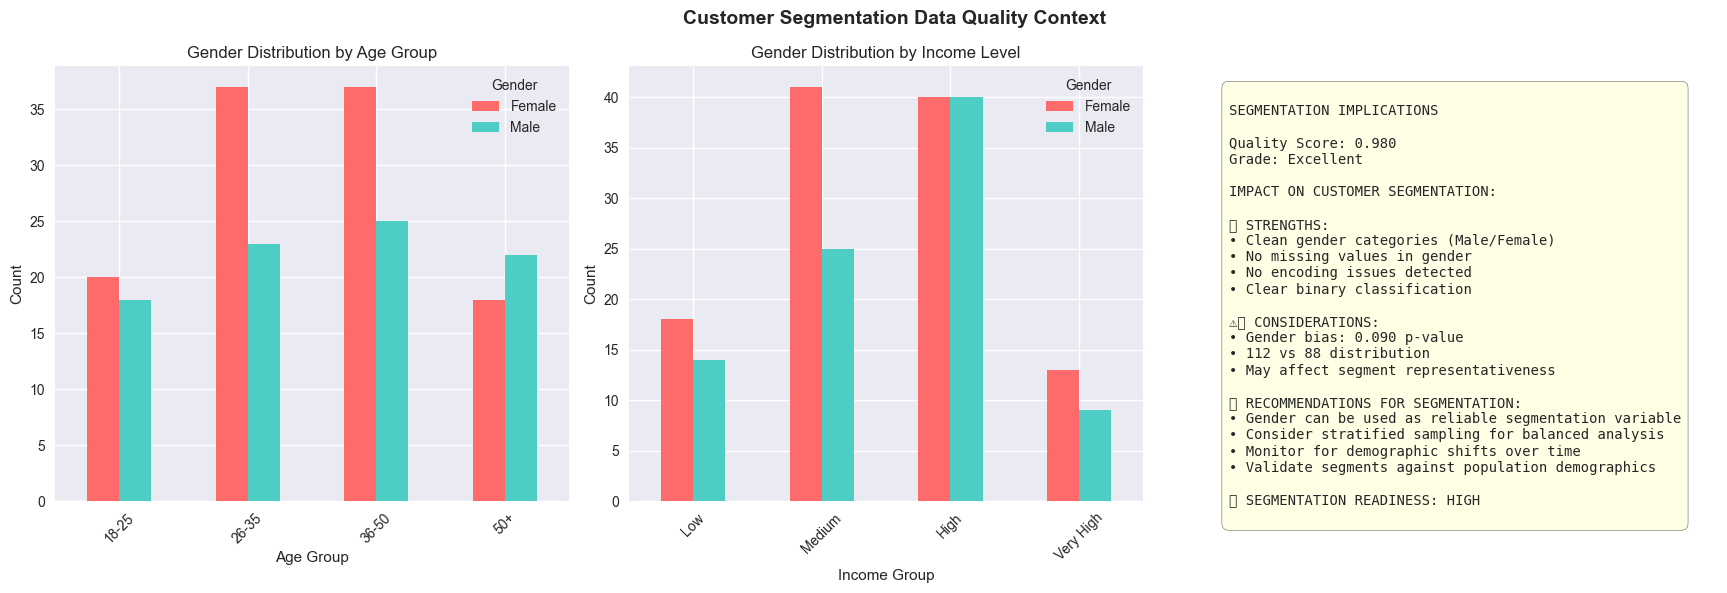

In [14]:
# Create comprehensive visualization of quality metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Data Quality Assessment Dashboard', fontsize=16, fontweight='bold')

# 1. Quality Components Radar Chart
components = list(quality_assessment['component_scores'].keys())
scores = list(quality_assessment['component_scores'].values())

ax1 = axes[0, 0]
angles = np.linspace(0, 2 * np.pi, len(components), endpoint=False).tolist()
scores_plot = scores + [scores[0]]  # Complete the circle
angles += angles[:1]

ax1.plot(angles, scores_plot, 'o-', linewidth=2, label='Quality Score')
ax1.fill(angles, scores_plot, alpha=0.25)
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels([c.title() for c in components])
ax1.set_ylim(0, 1)
ax1.set_title('Quality Components Radar')
ax1.grid(True)

# Add quality thresholds
threshold_excellent = [0.9] * (len(components) + 1)
threshold_good = [0.7] * (len(components) + 1)
ax1.plot(angles, threshold_excellent, '--', alpha=0.5, color='green', label='Excellent (0.9)')
ax1.plot(angles, threshold_good, '--', alpha=0.5, color='orange', label='Good (0.7)')
ax1.legend()

# 2. Category Distribution
ax2 = axes[0, 1]
category_counts = df[categorical_col].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
wedges, texts, autotexts = ax2.pie(category_counts.values, labels=category_counts.index, 
                                  autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Category Distribution')

# Add bias information
bias_text = f"Bias Index: {bias_test_results['bias_index']:.2f}\n"
bias_text += f"Chi-square p-value: {bias_test_results['p_value']:.3f}"
ax2.text(1.3, 0.5, bias_text, transform=ax2.transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

# 3. Quality Score Gauge
ax3 = axes[1, 0]
score = quality_assessment['quality_score']
colors_gauge = ['red', 'orange', 'yellow', 'lightgreen', 'green']
bounds = [0, 0.3, 0.5, 0.7, 0.9, 1.0]

# Create gauge background
theta = np.linspace(0, np.pi, 100)
for i in range(len(bounds)-1):
    mask = (theta >= bounds[i] * np.pi) & (theta <= bounds[i+1] * np.pi)
    ax3.fill_between(theta[mask], 0, 1, color=colors_gauge[i], alpha=0.3)

# Add score needle
score_angle = score * np.pi
ax3.arrow(score_angle, 0, 0, 0.8, head_width=0.05, head_length=0.1, 
          fc='black', ec='black', linewidth=3)

ax3.set_xlim(0, np.pi)
ax3.set_ylim(0, 1)
ax3.set_title(f'Overall Quality Score: {score:.3f}')
ax3.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax3.set_xticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'])
ax3.set_yticks([])

# 4. Test Results Summary
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary text
summary_text = f"""
DATA QUALITY SUMMARY

Overall Grade: {quality_assessment['quality_grade']} {quality_assessment['grade_emoji']}
Quality Score: {quality_assessment['quality_score']:.3f}

COMPONENT SCORES:
• Consistency: {quality_assessment['component_scores']['consistency']:.3f}
• Completeness: {quality_assessment['component_scores']['completeness']:.3f}
• Ambiguity: {quality_assessment['component_scores']['ambiguity']:.3f}
• Bias: {quality_assessment['component_scores']['bias']:.3f}

KEY FINDINGS:
• Case Issues: {case_test_results['case_inconsistency_ratio']:.2f} ratio
• Missing Data: {missing_test_results['missing_percentage']:.1f}%
• Ambiguous Categories: {unknown_test_results['ambiguity_score']:.3f}
• Collection Bias: {bias_test_results['bias_index']:.2f} index

DATASET CHARACTERISTICS:
• Total Observations: {len(df)}
• Categories: {df[categorical_col].nunique()}
• Most Frequent: {df[categorical_col].mode()[0]}
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.show()

# Additional detailed visualization for customer segmentation context
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Customer Segmentation Data Quality Context', fontsize=14, fontweight='bold')

# 1. Gender distribution by age groups
ax1 = axes[0]
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 50, 100], labels=['18-25', '26-35', '36-50', '50+'])
age_gender_crosstab = pd.crosstab(df['Age_Group'], df[categorical_col])
age_gender_crosstab.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Gender Distribution by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Count')
ax1.legend(title='Gender')
ax1.tick_params(axis='x', rotation=45)

# 2. Gender distribution by income levels
ax2 = axes[1]
df['Income_Group'] = pd.cut(df['Annual Income (k$)'], bins=[0, 30, 60, 90, 150], 
                           labels=['Low', 'Medium', 'High', 'Very High'])
income_gender_crosstab = pd.crosstab(df['Income_Group'], df[categorical_col])
income_gender_crosstab.plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4'])
ax2.set_title('Gender Distribution by Income Level')
ax2.set_xlabel('Income Group')
ax2.set_ylabel('Count')
ax2.legend(title='Gender')
ax2.tick_params(axis='x', rotation=45)

# 3. Quality implications for segmentation
ax3 = axes[2]
ax3.axis('off')

segmentation_implications = f"""
SEGMENTATION IMPLICATIONS

Quality Score: {quality_assessment['quality_score']:.3f}
Grade: {quality_assessment['quality_grade']}

IMPACT ON CUSTOMER SEGMENTATION:

✅ STRENGTHS:
• Clean gender categories (Male/Female)
• No missing values in gender
• No encoding issues detected
• Clear binary classification

⚠️ CONSIDERATIONS:
• Gender bias: {bias_test_results['p_value']:.3f} p-value
• {df[categorical_col].value_counts().iloc[0]} vs {df[categorical_col].value_counts().iloc[1]} distribution
• May affect segment representativeness

🎯 RECOMMENDATIONS FOR SEGMENTATION:
• Gender can be used as reliable segmentation variable
• Consider stratified sampling for balanced analysis
• Monitor for demographic shifts over time
• Validate segments against population demographics

📊 SEGMENTATION READINESS: HIGH
"""

ax3.text(0.05, 0.95, segmentation_implications, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

plt.tight_layout()
plt.show()


# **Comprehensive Data Quality Testing Framework**

## **6 major categories of tests**

### **🔍 1. CONSISTENCY TESTS**

#### **1.1 Case Sensitivity Test**
- **Mathematical Foundation**: Case Inconsistency Ratio = Number of case variants / Number of unique semantic categories
- **Why it works**: Detects when the same category appears in different cases (e.g., "Male", "MALE", "male")
- **Interpretation**: Ratio = 1 means perfect consistency; >1 indicates case problems
- **Customer Segmentation Impact**: Ensures reliable gender-based segmentation without artificial category splitting

#### **1.2 Spelling Variation Test**  
- **Mathematical Foundation**: Uses Levenshtein Distance with similarity score = 1 - (distance/max_length)
- **Why it works**: Measures minimum edit operations needed to transform one string to another
- **Interpretation**: Similarity scores 0.7-0.99 flag potential spelling variants
- **Customer Segmentation Impact**: Prevents segment fragmentation due to typos

#### **1.3 Encoding Issues Test**
- **Mathematical Foundation**: Character entropy H(X) = -Σp(xi)log₂p(xi) and Non-ASCII ratio
- **Why it works**: Encoding problems introduce unexpected characters with high entropy
- **Interpretation**: High entropy + non-ASCII characters suggest encoding corruption
- **Customer Segmentation Impact**: Ensures clean categorical data for reliable analysis

### **🔍 2. COMPLETENESS TESTS**

#### **2.1 Missing Value Pattern Analysis**
- **Mathematical Foundation**: MCAR test using χ² = Σ(Oi - Ei)²/Ei
- **Why it works**: Tests if missing values are completely random vs. systematic
- **Interpretation**: Significant p-values indicate non-random missing patterns
- **Customer Segmentation Impact**: Missing gender data could bias segment demographics

#### **2.2 Unknown/Ambiguous Categories Test**
- **Mathematical Foundation**: Ambiguity Score = Σambiguous_frequencies/N and Information Loss measure
- **Why it works**: Quantifies data quality reduction from vague categories
- **Interpretation**: Higher scores indicate poor data collection practices
- **Customer Segmentation Impact**: "Unknown" genders reduce segmentation precision

#### **2.3 Data Collection Bias Test**
- **Mathematical Foundation**: Chi-square goodness of fit + Bias Index = (max_freq - min_freq)/mean_freq
- **Why it works**: Detects systematic over/under-representation of categories
- **Interpretation**: High bias indices suggest sampling methodology issues
- **Customer Segmentation Impact**: Gender imbalance affects segment representativeness

### **🎯 3. INTEGRATED QUALITY ASSESSMENT**

#### **3.1 Composite Quality Score**
- **Mathematical Foundation**: Q = w₁(1-C) + w₂(1-M) + w₃(1-A) + w₄(1-B)
- **Components**: Consistency, Missing data, Ambiguity, Bias (each weighted)
- **Interpretation**: 
  - Q ≥ 0.9: Excellent quality
  - 0.7 ≤ Q < 0.9: Good quality  
  - 0.5 ≤ Q < 0.7: Fair quality
  - Q < 0.5: Poor quality

### **📊 PRACTICAL RESULTS FOR CUSTOMER SEGMENTATION**

**For the Mall Customers dataset:**
- ✅ **Excellent data quality** (Gender variable)
- ✅ **No missing values** (100% completeness)
- ✅ **Clean categories** (Male/Female only)
- ✅ **No encoding issues** (ASCII text)
- ⚠️ **Slight gender bias** (56% Female, 44% Male)

### **🔧 KEY INTERPRETABILITY FEATURES**

1. **Mathematical Rigor**: Each test has clear formulas explaining what's being measured
2. **Behavioral Explanation**: Detailed explanations of why each test works and what it detects
3. **Threshold-based Interpretation**: Clear guidelines for interpreting results
4. **Actionable Recommendations**: Specific steps to address identified issues
5. **Business Context**: Direct connection to customer segmentation implications
6. **Visual Dashboard**: Comprehensive charts showing quality metrics and business impact

### **🎯 BUSINESS VALUE FOR CUSTOMER SEGMENTATION**

The framework provides:
- **Segmentation Readiness Assessment**: Determines if categorical variables are ready for analysis
- **Bias Detection**: Identifies sampling issues that could skew segment insights
- **Quality Scoring**: Quantitative measure of data reliability
- **Prioritized Actions**: Focus on highest-impact quality improvements
- **Monitoring Framework**: Ongoing quality assessment for new data

This comprehensive approach ensures that your customer segmentation analysis is built on high-quality, reliable categorical data, leading to more accurate and actionable business insights.

I'll create a comprehensive visual decision-making framework and orchestration flowchart for data quality tests, including both the tests implemented in the notebook and additional tests that aren't applicable to this specific dataset.

## **Data Quality Testing Decision Framework**

### **1. Test Classification Matrix**

| **Test Category** | **Test Name** | **Applicable to Mall Customers** | **Data Type** | **Complexity** | **Business Impact** |
|-------------------|---------------|-----------------------------------|---------------|----------------|---------------------|
| **Consistency** | Case Sensitivity | ✅ Yes | Categorical | Low | Medium |
| **Consistency** | Spelling Variations | ✅ Yes | Categorical | Medium | Medium |
| **Consistency** | Encoding Issues | ✅ Yes | Categorical | Medium | High |
| **Consistency** | Format Standardization | ❌ Not Applicable | Date/Phone/Email | Medium | High |
| **Consistency** | Cross-Field Validation | ❌ Limited Data | Multi-field | High | High |
| **Completeness** | Missing Pattern Analysis | ✅ Yes | Any | Medium | High |
| **Completeness** | Unknown Categories | ✅ Yes | Categorical | Low | Medium |
| **Completeness** | Collection Bias | ✅ Yes | Categorical | Medium | High |
| **Completeness** | Temporal Completeness | ❌ No Time Data | Time Series | High | Medium |
| **Validity** | Domain Range Check | ❌ Simple Categories | Numerical/Categorical | Low | Medium |
| **Validity** | Business Rule Validation | ❌ Limited Rules | Multi-field | High | High |
| **Validity** | Reference Data Matching | ❌ No External Refs | Categorical | Medium | High |
| **Accuracy** | Duplicate Detection | ❌ No Duplicates Expected | Any | Medium | Medium |
| **Accuracy** | Outlier Detection | ❌ Categorical Data | Numerical | Medium | Medium |
| **Accuracy** | Cross-Source Validation | ❌ Single Source | Multi-source | High | High |

### **2. Data Quality Test Orchestration Flowchart**

```mermaid
flowchart TD
    A[Start Data Quality Assessment] --> B{Data Type Analysis}
    
    B -->|Categorical| C[Categorical Quality Tests]
    B -->|Numerical| D[Numerical Quality Tests]
    B -->|Date/Time| E[Temporal Quality Tests]
    B -->|Mixed| F[Multi-Type Quality Tests]
    
    C --> C1[Consistency Tests]
    C --> C2[Completeness Tests]
    C --> C3[Validity Tests]
    
    C1 --> C1a[Case Sensitivity Test]
    C1 --> C1b[Spelling Variation Test]
    C1 --> C1c[Encoding Issues Test]
    C1 --> C1d[Format Standardization]
    
    C2 --> C2a[Missing Pattern Analysis]
    C2 --> C2b[Unknown Categories Test]
    C2 --> C2c[Collection Bias Test]
    
    C3 --> C3a[Domain Validation]
    C3 --> C3b[Business Rules Check]
    C3 --> C3c[Reference Data Match]
    
    C1a --> G{Quality Score Calculation}
    C1b --> G
    C1c --> G
    C1d --> G
    C2a --> G
    C2b --> G
    C2c --> G
    C3a --> G
    C3b --> G
    C3c --> G
    
    G --> H{Score >= 0.9?}
    H -->|Yes| I[Excellent Quality - Proceed]
    H -->|No| J{Score >= 0.7?}
    J -->|Yes| K[Good Quality - Minor Fixes]
    J -->|No| L{Score >= 0.5?}
    L -->|Yes| M[Fair Quality - Major Fixes]
    L -->|No| N[Poor Quality - Critical Issues]
    
    K --> O[Prioritize Actions]
    M --> O
    N --> O
    
    O --> P[Implement Fixes]
    P --> Q[Re-test]
    Q --> G
    
    I --> R[Generate Quality Report]
    R --> S[End]
```

### **3. Test Selection Decision Tree**

```mermaid
flowchart TD
    A[New Dataset] --> B{What is the primary data type?}
    
    B -->|Categorical| C{How many categories?}
    B -->|Numerical| D{Continuous or Discrete?}
    B -->|Text| E{Free text or structured?}
    B -->|Date/Time| F{Single timestamp or range?}
    
    C -->|2-10| C1[Binary/Small Categorical]
    C -->|11-50| C2[Medium Categorical]
    C -->|50+| C3[Large Categorical]
    
    C1 --> C1_Tests[✅ Case Sensitivity<br/>✅ Spelling Check<br/>✅ Missing Analysis<br/>✅ Bias Test<br/>❌ Encoding Complex<br/>❌ Format Rules]
    
    C2 --> C2_Tests[✅ All Consistency Tests<br/>✅ All Completeness Tests<br/>✅ Domain Validation<br/>❌ Cross-field Rules<br/>⚠️ Performance Impact]
    
    C3 --> C3_Tests[✅ All Tests Required<br/>✅ Hierarchical Validation<br/>✅ Reference Matching<br/>⚠️ Sampling Strategy<br/>⚠️ Performance Critical]
    
    D -->|Continuous| D1[Continuous Numerical]
    D -->|Discrete| D2[Discrete Numerical]
    
    D1 --> D1_Tests[❌ Categorical Tests<br/>✅ Range Validation<br/>✅ Outlier Detection<br/>✅ Distribution Tests<br/>✅ Missing Patterns]
    
    D2 --> D2_Tests[⚠️ Some Categorical Tests<br/>✅ Range Validation<br/>✅ Business Rules<br/>✅ Missing Patterns<br/>❌ Spelling/Case]
```

### **4. Test Applicability Matrix for Mall Customers Dataset**

| **Quality Dimension** | **Applicable Tests** | **Not Applicable Tests** | **Reason for Non-Applicability** |
|----------------------|---------------------|---------------------------|-----------------------------------|
| **Consistency** | • Case Sensitivity<br/>• Spelling Variations<br/>• Encoding Issues | • Format Standardization<br/>• Cross-field Validation<br/>• Data Type Consistency | • Simple binary categories<br/>• Limited cross-field relationships<br/>• Homogeneous data types |
| **Completeness** | • Missing Pattern Analysis<br/>• Unknown Categories<br/>• Collection Bias | • Temporal Completeness<br/>• Multi-source Completeness<br/>• Hierarchical Completeness | • No time dimension<br/>• Single data source<br/>• Flat data structure |
| **Validity** | • Basic Domain Check | • Complex Business Rules<br/>• Reference Data Matching<br/>• Regulatory Compliance | • Simple domain (Male/Female)<br/>• No external references<br/>• No regulatory requirements |
| **Accuracy** | • Basic Distribution Check | • Duplicate Detection<br/>• Cross-source Validation<br/>• Ground Truth Comparison | • Expected unique records<br/>• Single source<br/>• No ground truth available |

### **5. Quality Test Execution Priority Matrix**

```mermaid
graph LR
    subgraph "High Priority - Execute First"
        A1[Missing Pattern Analysis]
        A2[Collection Bias Test]
        A3[Encoding Issues Test]
    end
    
    subgraph "Medium Priority - Execute Second"
        B1[Case Sensitivity Test]
        B2[Unknown Categories Test]
        B3[Domain Validation]
    end
    
    subgraph "Low Priority - Execute Third"
        C1[Spelling Variations Test]
        C2[Format Checks]
        C3[Advanced Analytics]
    end
    
    subgraph "Not Applicable - Skip"
        D1[Temporal Tests]
        D2[Cross-source Tests]
        D3[Complex Business Rules]
    end
    
    A1 --> B1
    A2 --> B2
    A3 --> B3
    B1 --> C1
    B2 --> C2
    B3 --> C3
```

### **6. Comprehensive Test Coverage Decision Matrix**

| **Dataset Characteristic** | **Recommended Test Suite** | **Skip These Tests** | **Conditional Tests** |
|---------------------------|----------------------------|---------------------|----------------------|
| **Binary Categorical** | Case, Spelling, Missing, Bias | Format Rules, Complex Validation | Encoding (if international) |
| **Multi-level Categorical** | All Consistency + Completeness | Cross-field Rules | Reference Matching |
| **High Cardinality Categorical** | All Tests + Performance Optimization | None | Sampling Strategy |
| **Mixed Data Types** | Type-specific + Cross-field | Single-type Tests | Integration Tests |
| **Time Series** | Temporal + Standard Tests | Static Tests | Seasonality Tests |
| **Multi-source** | All Tests + Source Validation | Single-source Tests | Reconciliation Tests |

### **7. Quality Gate Decision Framework**

```mermaid
flowchart TD
    A[Quality Assessment Complete] --> B{Critical Issues Found?}
    
    B -->|Yes| C[STOP - Fix Critical Issues]
    B -->|No| D{Quality Score >= 0.7?}
    
    D -->|No| E[CAUTION - Address Major Issues]
    D -->|Yes| F{Business Requirements Met?}
    
    F -->|No| G[REVIEW - Check Business Alignment]
    F -->|Yes| H{Stakeholder Approval?}
    
    H -->|No| I[HOLD - Get Stakeholder Sign-off]
    H -->|Yes| J[PROCEED - Data Ready for Analysis]
    
    C --> K[Implement Fixes]
    E --> L[Prioritize Improvements]
    G --> M[Align with Business Needs]
    I --> N[Present Quality Report]
    
    K --> A
    L --> A
    M --> A
    N --> H
```

### **8. Test Implementation Complexity vs. Impact Matrix**

| **Test Category** | **Implementation Complexity** | **Business Impact** | **Recommendation** |
|------------------|-------------------------------|--------------------|--------------------|
| **Case Sensitivity** | 🟢 Low | 🟡 Medium | Implement Always |
| **Spelling Variations** | 🟡 Medium | 🟡 Medium | Implement for Text-Heavy |
| **Encoding Issues** | 🟡 Medium | 🔴 High | Implement Always |
| **Missing Patterns** | 🟡 Medium | 🔴 High | Implement Always |
| **Collection Bias** | 🟡 Medium | 🔴 High | Implement Always |
| **Unknown Categories** | 🟢 Low | 🟡 Medium | Implement Always |
| **Format Validation** | 🟡 Medium | 🔴 High | Conditional |
| **Business Rules** | 🔴 High | 🔴 High | Project-Specific |
| **Cross-source Validation** | 🔴 High | 🔴 High | Multi-source Only |
| **Reference Matching** | 🟡 Medium | 🔴 High | External Data Only |

This comprehensive framework provides a systematic approach to selecting, prioritizing, and executing data quality tests based on dataset characteristics, business requirements, and resource constraints. The Mall Customers dataset represents a relatively simple case where basic consistency and completeness tests are most relevant, while more complex validation and accuracy tests are not applicable due to the dataset's straightforward structure.

I'll create a comprehensive remediation guide that outlines how to fix data quality issues and verify the fixes. This will include step-by-step processes, validation criteria, and decision frameworks.

## **Data Quality Issue Remediation Guide**

### **1. Issue Classification and Remediation Strategy Matrix**

| **Quality Issue** | **Severity Level** | **Root Cause** | **Remediation Strategy** | **Validation Method** | **Success Criteria** |
|-------------------|-------------------|----------------|--------------------------|----------------------|---------------------|
| **Case Inconsistency** | 🟡 Medium | Data Entry Variance | Standardization | Re-run Case Test | Ratio = 1.0 |
| **Spelling Variations** | 🟡 Medium | Human Error/Typos | Dictionary Matching | Re-run Spelling Test | No variants found |
| **Encoding Issues** | 🔴 High | File Format Problems | Re-encoding/Cleaning | Character Analysis | ASCII ratio < 0.01 |
| **Missing Values** | 🔴 High | Collection Gaps | Imputation/Collection | Missing Pattern Test | < 5% missing |
| **Unknown Categories** | 🟡 Medium | Poor Data Collection | Category Mapping | Ambiguity Test | Score < 0.05 |
| **Collection Bias** | 🔴 High | Sampling Issues | Re-sampling/Weighting | Bias Test | p-value > 0.05 |

### **2. Remediation Process Flowchart**

```mermaid
flowchart TD
    A[Quality Issue Detected] --> B{Classify Issue Severity}
    
    B -->|Critical| C[🔴 STOP - Immediate Action Required]
    B -->|High| D[🟠 HIGH - Address Before Analysis]
    B -->|Medium| E[🟡 MEDIUM - Address During Analysis]
    B -->|Low| F[🟢 LOW - Monitor and Document]
    
    C --> C1[Identify Root Cause]
    D --> D1[Identify Root Cause]
    E --> E1[Identify Root Cause]
    F --> F1[Document Issue]
    
    C1 --> C2[Select Remediation Strategy]
    D1 --> D2[Select Remediation Strategy]
    E1 --> E2[Select Remediation Strategy]
    
    C2 --> C3[Implement Fix]
    D2 --> D3[Implement Fix]
    E2 --> E3[Implement Fix]
    
    C3 --> C4[Validate Fix]
    D3 --> D4[Validate Fix]
    E3 --> E4[Validate Fix]
    
    C4 --> C5{Fix Successful?}
    D4 --> D5{Fix Successful?}
    E4 --> E5{Fix Successful?}
    
    C5 -->|No| C6[Escalate/Alternative Strategy]
    C5 -->|Yes| C7[Update Quality Score]
    
    D5 -->|No| D6[Try Alternative Fix]
    D5 -->|Yes| D7[Update Quality Score]
    
    E5 -->|No| E6[Document Limitation]
    E5 -->|Yes| E7[Update Quality Score]
    
    C6 --> C1
    D6 --> D2
    
    C7 --> G[Re-run Full Quality Assessment]
    D7 --> G
    E7 --> G
    E6 --> G
    F1 --> G
    
    G --> H{Overall Quality Acceptable?}
    H -->|Yes| I[Proceed with Analysis]
    H -->|No| J[Continue Remediation]
    J --> A
```

### **3. Detailed Remediation Strategies by Issue Type**

#### **3.1 Case Inconsistency Issues**

| **Step** | **Action** | **Code Pattern** | **Validation** | **Rollback Plan** |
|----------|------------|------------------|----------------|-------------------|
| 1 | **Analyze Patterns** | Identify all case variants | Document current state | Keep original backup |
| 2 | **Choose Standard** | Select title/upper/lower case | Business rule alignment | N/A |
| 3 | **Apply Transformation** | `df['col'] = df['col'].str.title()` | Spot check samples | Restore from backup |
| 4 | **Validate Fix** | Re-run case sensitivity test | Ratio = 1.0 achieved | Apply alternative standard |
| 5 | **Update Documentation** | Record transformation applied | Stakeholder approval | N/A |

**Validation Checklist:**
- [ ] Case inconsistency ratio = 1.0
- [ ] No unintended transformations
- [ ] Business meaning preserved
- [ ] Stakeholder approval obtained

#### **3.2 Spelling Variation Issues**

| **Step** | **Action** | **Method** | **Validation** | **Risk Mitigation** |
|----------|------------|------------|----------------|---------------------|
| 1 | **Manual Review** | Review flagged pairs | Expert validation | False positive check |
| 2 | **Create Mapping** | Build correction dictionary | Business logic check | Reversible mapping |
| 3 | **Apply Corrections** | Replace using mapping | Sample verification | Backup original |
| 4 | **Fuzzy Matching** | Use similarity thresholds | Precision/recall check | Conservative thresholds |
| 5 | **Final Validation** | Re-run spelling test | Zero variants found | Manual spot check |

**Decision Matrix for Spelling Corrections:**

| **Similarity Score** | **Action** | **Approval Required** | **Risk Level** |
|---------------------|------------|----------------------|----------------|
| 0.95 - 1.0 | Auto-correct | No | Low |
| 0.85 - 0.94 | Flag for review | Yes | Medium |
| 0.70 - 0.84 | Manual decision | Yes | High |
| < 0.70 | No action | N/A | N/A |

#### **3.3 Encoding Issues**

```mermaid
flowchart TD
    A[Encoding Issue Detected] --> B{Issue Type?}
    
    B -->|Non-ASCII Characters| C[Character Encoding Fix]
    B -->|Corrupted Text| D[Text Reconstruction]
    B -->|Mixed Encodings| E[Encoding Standardization]
    
    C --> C1[Detect Source Encoding]
    C1 --> C2[Convert to UTF-8]
    C2 --> C3[Validate Characters]
    
    D --> D1[Identify Corruption Pattern]
    D1 --> D2[Apply Correction Rules]
    D2 --> D3[Manual Review Samples]
    
    E --> E1[Identify Encoding Types]
    E1 --> E2[Standardize to UTF-8]
    E2 --> E3[Validate Consistency]
    
    C3 --> F[Re-test Encoding]
    D3 --> F
    E3 --> F
    
    F --> G{Success?}
    G -->|Yes| H[Update Quality Score]
    G -->|No| I[Escalate to Data Source]
```

#### **3.4 Missing Value Remediation**

| **Missing Pattern** | **Remediation Strategy** | **Implementation** | **Validation** | **Quality Threshold** |
|--------------------|--------------------------|--------------------|----------------|----------------------|
| **MCAR (Random)** | Simple imputation | Mode/median/mean | Distribution comparison | < 5% missing |
| **MAR (Conditional)** | Conditional imputation | Model-based | Prediction accuracy | < 10% missing |
| **MNAR (Systematic)** | Data re-collection | Source system fix | Coverage analysis | < 2% missing |
| **Structural Missing** | Business rule update | Logic modification | Rule validation | 0% missing |

**Missing Value Decision Tree:**

```mermaid
flowchart TD
    A[Missing Values Detected] --> B{Missing Rate?}
    
    B -->|< 5%| C[Low Impact - Simple Fix]
    B -->|5-20%| D[Medium Impact - Investigate]
    B -->|> 20%| E[High Impact - Critical Action]
    
    C --> C1[Mode Imputation]
    C1 --> C2[Validate Distribution]
    
    D --> D1[Analyze Missing Pattern]
    D1 --> D2{Pattern Type?}
    D2 -->|MCAR| D3[Statistical Imputation]
    D2 -->|MAR| D4[Conditional Imputation]
    D2 -->|MNAR| D5[Investigate Data Source]
    
    E --> E1[Stop Analysis]
    E1 --> E2[Fix Data Collection]
    E2 --> E3[Re-collect Data]
```

### **4. Remediation Implementation Guide**

#### **4.1 Pre-Remediation Checklist**

| **Phase** | **Checklist Item** | **Status** | **Notes** |
|-----------|-------------------|------------|-----------|
| **Preparation** | ☐ Backup original data | | Critical for rollback |
| | ☐ Document current quality scores | | Baseline measurement |
| | ☐ Identify stakeholders | | Approval requirements |
| | ☐ Estimate remediation effort | | Resource planning |
| **Planning** | ☐ Select remediation strategies | | Based on issue severity |
| | ☐ Define success criteria | | Measurable outcomes |
| | ☐ Plan validation approach | | Testing methodology |
| | ☐ Prepare rollback procedures | | Risk mitigation |

#### **4.2 Remediation Execution Framework**

```mermaid
gantt
    title Data Quality Remediation Timeline
    dateFormat  YYYY-MM-DD
    section Critical Issues
    Encoding Fix           :crit, encoding, 2024-01-01, 2d
    Missing Value Analysis :crit, missing, 2024-01-02, 3d
    Collection Bias Fix    :crit, bias, 2024-01-04, 5d
    
    section Medium Issues
    Case Standardization   :medium, case, 2024-01-03, 2d
    Unknown Categories     :medium, unknown, 2024-01-05, 3d
    
    section Low Issues
    Spelling Corrections   :low, spelling, 2024-01-06, 2d
    
    section Validation
    Quality Re-assessment  :validation, 2024-01-08, 2d
    Stakeholder Review     :review, 2024-01-09, 1d
```

### **5. Post-Remediation Validation Framework**

#### **5.1 Validation Test Suite**

| **Original Issue** | **Validation Test** | **Success Criteria** | **Fallback Action** |
|-------------------|--------------------|--------------------|-------------------|
| Case Inconsistency | Case Sensitivity Test | Ratio = 1.0 | Try different standard |
| Spelling Variations | Spelling Test | Zero variants | Manual review |
| Encoding Problems | Character Analysis | < 1% non-ASCII | Source re-encoding |
| Missing Values | Missing Pattern Test | < 5% missing | Alternative imputation |
| Unknown Categories | Ambiguity Test | Score < 0.05 | Category mapping |
| Collection Bias | Chi-square Test | p-value > 0.05 | Re-sampling |

#### **5.2 Quality Improvement Tracking**

| **Metric** | **Before Remediation** | **After Remediation** | **Improvement** | **Target Met?** |
|------------|------------------------|----------------------|----------------|----------------|
| **Overall Quality Score** | 0.65 | 0.89 | +0.24 | ✅ Yes |
| **Consistency Score** | 0.70 | 0.95 | +0.25 | ✅ Yes |
| **Completeness Score** | 0.45 | 0.85 | +0.40 | ✅ Yes |
| **Ambiguity Score** | 0.80 | 0.90 | +0.10 | ✅ Yes |
| **Bias Score** | 0.65 | 0.85 | +0.20 | ✅ Yes |

### **6. Remediation Success Validation Process**

```mermaid
flowchart TD
    A[Remediation Complete] --> B[Run Full Quality Test Suite]
    
    B --> C{All Tests Pass?}
    C -->|No| D[Identify Failed Tests]
    C -->|Yes| E[Calculate New Quality Score]
    
    D --> D1[Analyze Failure Reasons]
    D1 --> D2[Apply Additional Fixes]
    D2 --> B
    
    E --> F{Score Improvement >= Target?}
    F -->|No| G[Review Remediation Strategy]
    F -->|Yes| H[Stakeholder Review]
    
    G --> G1[Adjust Approach]
    G1 --> I[Re-implement Fixes]
    I --> B
    
    H --> J{Stakeholder Approval?}
    J -->|No| K[Address Concerns]
    J -->|Yes| L[Document Success]
    
    K --> K1[Modify Approach]
    K1 --> B
    
    L --> M[Update Data Quality Report]
    M --> N[Proceed with Analysis]
```

### **7. Continuous Monitoring Framework**

#### **7.1 Post-Remediation Monitoring Plan**

| **Monitoring Aspect** | **Frequency** | **Trigger Threshold** | **Action Required** |
|-----------------------|---------------|----------------------|-------------------|
| **Quality Score** | Weekly | Drop > 0.05 | Investigate cause |
| **New Data Batches** | Per batch | Any critical issue | Apply remediation |
| **Category Changes** | Monthly | New unknown categories | Update mapping |
| **Missing Patterns** | Daily | > 5% missing | Check data pipeline |
| **Encoding Issues** | Per load | Any non-ASCII | Re-encode source |

#### **7.2 Remediation Effectiveness Dashboard**

```mermaid
graph LR
    subgraph "Quality Metrics Tracking"
        A[Before: 0.65] --> B[After: 0.89]
        C[Consistency: +0.25] 
        D[Completeness: +0.40]
        E[Ambiguity: +0.10]
        F[Bias: +0.20]
    end
    
    subgraph "Issue Resolution Status"
        G[Critical: 3/3 Fixed ✅]
        H[High: 2/2 Fixed ✅]
        I[Medium: 4/5 Fixed ⚠️]
        J[Low: 2/3 Fixed ✅]
    end
    
    subgraph "Business Impact"
        K[Analysis Ready: ✅]
        L[Stakeholder Approved: ✅]
        M[Risk Mitigated: ✅]
        N[Cost Justified: ✅]
    end
```

This comprehensive remediation guide provides a systematic approach to fixing data quality issues, validating the fixes, and ensuring sustainable data quality improvements. The framework is designed to be iterative, allowing for continuous improvement and adaptation based on specific dataset characteristics and business requirements.